In [1]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

# custom classes and functions
import models
from models.blocks import ConvBlock, TransposeConvBlock, ResConvBlock, CategoricalStraightThrough
from models.autoencoder import Autoencoder
from models.vae import VAE
from models.categorical_vae import CategoricalVAE
from preprocessing import grayscale_transform as transform

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Create VAE

In [3]:
batch_size = 8

# VAE
vae = CategoricalVAE(
    greyscale=True,
    vae_ent_coeff=1e-8
).to(device)

# VAE optimizer
vae_optim = optim.Adam(
    vae.parameters(), 
    lr=1e-3,
    weight_decay=1e-5 # l2 regularization
)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# display VAE stats
vae.info()

| CategoricalVAE info |
-----------------------
device: cuda
number of parameters: 38_151_857
input shape : [8, 1, 128, 128]
hidden shape: [8, 32, 32]
output shape: [8, 1, 128, 128]
vae_ent_coeff: 1e-08


## RSSM

```py

- given: h, obs (obs is given only in training mode)

# predict z from h
z_pred = dynamics_mlp(h)

# get true z from encoder
z_sample = vae.encode(obs) # returns one-hot on softmax sample

state = concat(h,z)

# apply actor and critic nets on state
v = val_net(state)
a = actor_critic(state) # a is a 2x1 vector

# predict other stuff
r = reward_mlp(state)
c = continue_mlp(state) # binary classification

# combine everything into belief state
x = concat(a, state)


# apply rnn
h_new = rnn(x, h)
```

## Create RNN

In [215]:
A = 3 # number of action dimensions (3 for toy, 2 for real sim)
H = 512 # discrete h state 
Z = 32*32 # stochastic Zx1 state
num_rnn_layers = 1

rnn = nn.GRU(
    input_size=A+H+Z,
    hidden_size=H,
    num_layers=num_rnn_layers
).to(device)

h = torch.zeros(num_rnn_layers, 1, H) # seq_len, B, H

print(f"RNN ==> number of parameters: {sum(p.numel() for p in rnn.parameters() if p.requires_grad):_}")

RNN ==> number of parameters: 3_153_408


In [211]:
dynamics_mlp = lambda x: torch.randn(Z , device=device)

val_net = lambda x: torch.randn(1 , device=device)

policy_net = lambda x: torch.randn(A , device=device)

reward_mlp = lambda x: torch.randn(1 , device=device)
continue_mlp = lambda x: torch.tensor([int(torch.randn(1, device=device) > 0.5)]) # 0 or 1

## Training loop

In [237]:
""" vae training loop """

# create the environment
toy_env = True

if toy_env:
    env = gym.make("CarRacing-v2", max_episode_steps=40, render_mode="rgb_array")
else:
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

verbose = True
n_episodes = 100
vae_losses, reconstruction_losses, entropy_losses = [], [], []
vae.train()

for episode in range(n_episodes): # tqdm
    
    # get the initial state
    obs, info = env.reset()
    
    # reset the rnn's hidden state
    h = torch.zeros(num_rnn_layers, 1, H, device=device) # seq_len, B, H
    
    # setup a minibatch of x's for training the autoencoder
    batch_counter = 0
    batch_tensor = torch.empty((batch_size,) + transform(obs).shape, device=device) # B,C,H,W
    
    # play one episode
    done = False
    while not done:
             
        # add the new x to the batch
        x = transform(obs).view(-1, 1, 128, 128)
        batch_tensor[batch_counter] = transform(obs)
        batch_counter += 1
        
        """ train networks on accumulated batch """
        if batch_counter % batch_size == 0:
            # reset the batch counter
            batch_counter = 0
            
            # autoencoder forward pass with a minibatch
            xhat = vae(batch_tensor)

            # get a loss and update the autoencoder
            vae_loss, reconstruction_loss, weighted_entropy_loss = vae.get_loss(batch_tensor, xhat)
            vae_optim.zero_grad()
            vae_loss.backward()
            vae_optim.step()
            
            vae_losses.append(vae_loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            entropy_losses.append(weighted_entropy_loss.item())
        
        # predict z from h
        z_pred = dynamics_mlp(h).view(-1, Z) # B,1024 (flattened)
        
        # get true z from encoder
        z = vae.encode(x).view(-1, Z) # B,1024 (flattened)
        
        state = torch.cat((h.view(-1, H), z), 1) # 1 (B), H+Z
        
        # apply actor and critic nets on state
        v = val_net(state)
        action = policy_net(state) # a is a 2x1 vector
        
        # predict other stuff
        r = reward_mlp(state)
        c = continue_mlp(state) # binary classification
        
        # combine everything and apply the rnn to get the next hidden state
        rnn_input = torch.cat((action.unsqueeze(0), state), dim=1)
        _, h = rnn(rnn_input, h.view(-1, H))
        
        # choose and execute an action
        # action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action.cpu().numpy())        
               
        done = terminated or truncated
        obs = next_obs
    
    if verbose: 
        print(f"train episode [{episode}/{n_episodes}] ===> Loss: {vae_loss.item():.3f}, ReconstructionLoss: {reconstruction_loss.item():.3f}, weighted_entropy_loss: {weighted_entropy_loss.item():.3f}, lr: {get_lr(vae_optim)}")
        
env.close()

train episode [0/100] ===> Loss: 0.648, ReconstructionLoss: 0.648, weighted_entropy_loss: -0.000, lr: 0.001
train episode [1/100] ===> Loss: 0.609, ReconstructionLoss: 0.609, weighted_entropy_loss: -0.000, lr: 0.001
train episode [2/100] ===> Loss: 0.717, ReconstructionLoss: 0.717, weighted_entropy_loss: -0.000, lr: 0.001
train episode [3/100] ===> Loss: 0.772, ReconstructionLoss: 0.772, weighted_entropy_loss: -0.000, lr: 0.001


KeyboardInterrupt: 

## Plot results

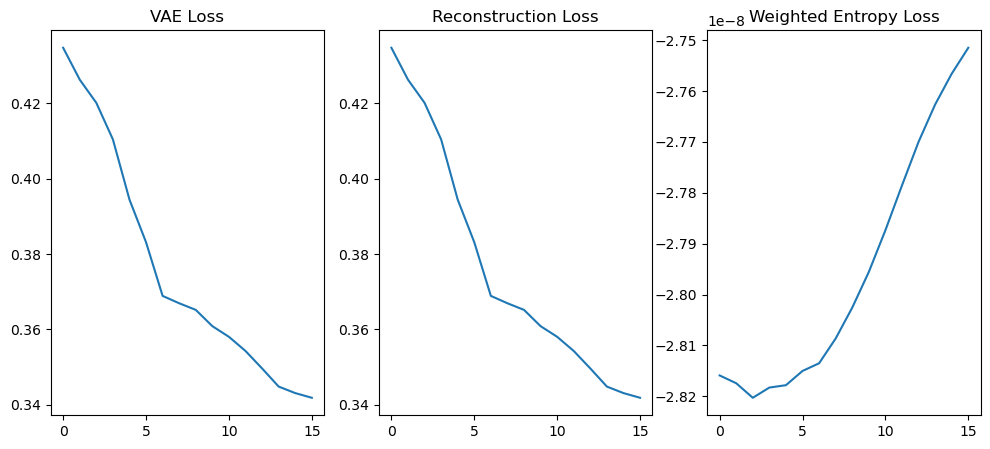

In [12]:
rolling_length = 1

fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("VAE Loss")
vae_losses_moving_average = (
    np.convolve(
        np.array(vae_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(vae_losses_moving_average)), vae_losses_moving_average)


axs[1].set_title("Reconstruction Loss")
reconstruction_losses_moving_average = (
    np.convolve(
        np.array(reconstruction_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].plot(range(len(reconstruction_losses_moving_average)), reconstruction_losses_moving_average)

axs[2].set_title("Weighted Entropy Loss")
entropy_losses_moving_average = (
    np.convolve(
        np.array(entropy_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[2].plot(range(len(entropy_losses_moving_average)), entropy_losses_moving_average);

# Overfitting and visualization playground

In [11]:
""" overfit to one sample """
batch_tensor = torch.load("batch_tensor.pt").to(device)
vae_losses, reconstruction_losses, entropy_losses = [], [], []

for i in range(200):
    
    xhat = vae(batch_tensor)

    # get a loss and update the autoencoder
    vae_loss, reconstruction_loss, entropy_loss = vae.get_loss(batch_tensor, xhat)
    vae_optim.zero_grad()
    vae_loss.backward()
    vae_optim.step()

    vae_losses.append(vae_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    entropy_losses.append(entropy_loss.item())

    if i % 20 == 0:
        print(f"[{i+1}/{200}] loss: {vae_loss.item()}, entropy loss: {entropy_loss}, lr: {get_lr(vae_optim)}")

[1/200] loss: 0.43471699953079224, entropy loss: -2.8158936515865207e-08, lr: 0.001


KeyboardInterrupt: 

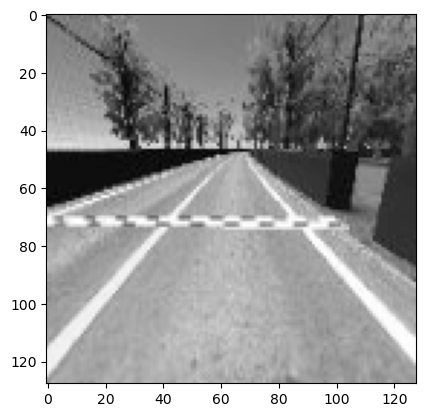

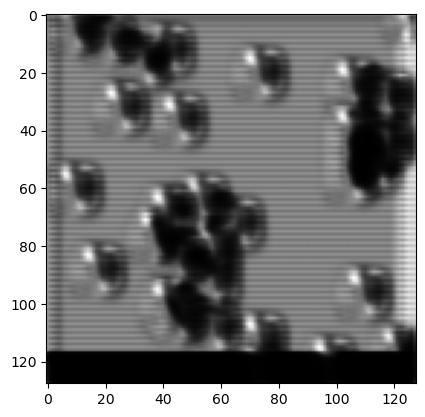

In [10]:
batch_tensor = torch.load("batch_tensor.pt").to(device)

""" show the observation """
plt.imshow(torch.permute(batch_tensor[0].cpu(), (1,2,0)), cmap="gray")
plt.show()

""" show the reconstruction """
vae.eval()
with torch.no_grad():
    xhat = vae(batch_tensor)
    plt.imshow(torch.permute(xhat[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
vae.train();